<a href="https://colab.research.google.com/github/MarcoParola/medical_images_classification/blob/main/Ensemble_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import collections 
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from numpy import array
from numpy import argmax

In [ ]:
projectPath = 'drive/MyDrive/Colab Notebooks/cidl/'
dataPath = 'numpy data/'

In [ ]:
%cd $projectPath
%run utils.ipynb
%cd '../../../..'

/content/drive/MyDrive/Colab Notebooks/cidl
/content


In [ ]:
# load data
imagesTrainPub, labelsTrainPub, imagesTestPub, labelsTestPub, imagesTestPriv = load_data(projectPath + dataPath)

# normalize data 
imagesTrainPub = scaleData(imagesTrainPub)
imagesTestPub = scaleData(imagesTestPub)

In [ ]:
# create (if not exists) the folder to store the models
dir_name = 'models/'
if not os.path.exists(projectPath + dir_name):
  os.makedirs(projectPath + dir_name)

# **Load data to classify**

In [ ]:
# 0 -> mass
# 1 -> calcification

# prepare test-set
testSet = []
testLabels = []

for i in range(len(labelsTestPub)):
  if labelsTestPub[i] == 1 or labelsTestPub[i] == 2:
    testSet.append(imagesTestPub[i])
    testLabels.append(0)
  if labelsTestPub[i] == 3 or labelsTestPub[i] == 4:
    testSet.append(imagesTestPub[i])
    testLabels.append(1)

testSet = np.array(testSet)
testSet = testSet.reshape(336, 150, 150, 1)

# the output must have a categorigal values
testLabelsCategorical = to_categorical(np.array(testLabels))

In [ ]:
# 0 -> benign
# 1 -> malignant

# prepare test-set
testSet2 = []
testLabels2 = []

for i in range(len(labelsTestPub)):
  if labelsTestPub[i] == 1 or labelsTestPub[i] == 3:
    testSet2.append(imagesTestPub[i])
    testLabels2.append(0)
  if labelsTestPub[i] == 2 or labelsTestPub[i] == 4:
    testSet2.append(imagesTestPub[i])
    testLabels2.append(1)

testSet2 = np.array(testSet2)
testSet2 = testSet2.reshape(336, 150, 150, 1)

# the output must have a categorigal values
testLabelsCategorical2 = to_categorical(np.array(testLabels2))

In [ ]:
def ensemble_predictions_avg(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# weighted sum across ensemble members
	summed = np.tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = argmax(summed, axis=1)
	return result

In [ ]:
def ensemble_predictions_majority(members, weights, testX):
  # make predictions
  yhats = [model.predict_classes(testX) for model in members]
  pred = []
  for j in range(len(testX)):
    prediction = 0
    class0 = 0
    class1 = 0
    for i in range(len(members)):
      if yhats[i][j] == 0:
        class0 = class0 +1
      else:
        class1 = class1 + 1
    if class0 > class1:
      pred.append(0)
    else:
      pred.append(1)

  return pred


In [ ]:
def show_results(prediction, testLabels, classes):
  cm = metrics.confusion_matrix(prediction, testLabels)
  plt.imshow(cm, interpolation='nearest', cmap='OrRd')
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  print(tick_marks)
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  cm = np.round( cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] ,2)
  print("Normalized confusion matrix")
  thresh = 0.6

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  print(metrics.accuracy_score(testLabels,prediction))

# **Ensamble 2.1**

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 1]
Normalized confusion matrix


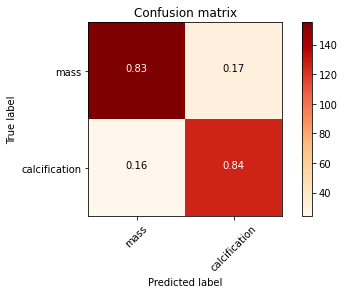

0.8363095238095238
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       179
           1       0.84      0.80      0.82       157

    accuracy                           0.84       336
   macro avg       0.84      0.83      0.84       336
weighted avg       0.84      0.84      0.84       336

[0 1]
Normalized confusion matrix


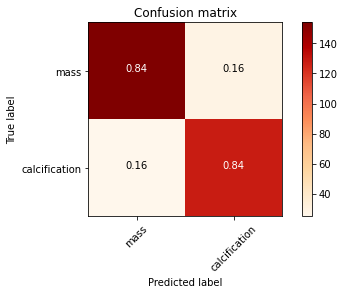

0.8392857142857143
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       179
           1       0.84      0.82      0.83       157

    accuracy                           0.84       336
   macro avg       0.84      0.84      0.84       336
weighted avg       0.84      0.84      0.84       336



In [ ]:
dir1 = projectPath + dir_name + "/task2_1/"

model1 = keras.models.load_model(os.path.join(dir1, "model1.h5"))
pred1 = model1.predict_classes(testSet)
acc1 = metrics.accuracy_score(testLabels, pred1)

model2 = keras.models.load_model(os.path.join(dir1,"model2.h5"))
pred2 = model2.predict_classes(testSet)
acc2 = metrics.accuracy_score(testLabels, pred2)

model3 = keras.models.load_model(os.path.join(dir1,"model3.h5"))
pred3 = model3.predict_classes(testSet)
acc3 = metrics.accuracy_score(testLabels, pred3)

weights = [acc1, acc2, acc3]
models = [model1, model2, model3]

resAvg = ensemble_predictions_avg(models, weights, testSet)
resMaj = ensemble_predictions_majority(models, weights, testSet)


show_results(resAvg, testLabels, ['mass', 'calcification'])
print(metrics.classification_report(testLabels, resAvg))

show_results(resMaj, testLabels, ['mass', 'calcification'])
print(metrics.classification_report(testLabels, resMaj))

# **Ensamble 2.2**

In [ ]:
dir1 = projectPath + dir_name + "/task2_2/"

model1 = keras.models.load_model(os.path.join(dir1, "model1.h5"))
pred1 = model1.predict_classes(testSet)
acc1 = metrics.accuracy_score(testLabels, pred1)

model2 = keras.models.load_model(os.path.join(dir1,"model2.h5"))
pred2 = model2.predict_classes(testSet)
acc2 = metrics.accuracy_score(testLabels, pred2)

model3 = keras.models.load_model(os.path.join(dir1,"model3.h5"))
pred3 = model3.predict_classes(testSet)
acc3 = metrics.accuracy_score(testLabels, pred3)

weights = [acc1, acc2, acc3]
models = [model1, model2, model3]

resAvg = ensemble_predictions_avg(models, weights, testSet2)
resMaj = ensemble_predictions_majority(models, weights, testSet2)


show_results(resAvg, testLabels, ['benign', 'malignant'])
print(metrics.classification_report(testLabels2, resAvg))

show_results(resMaj, testLabels, ['benign', 'malignant'])
print(metrics.classification_report(testLabels2, resMaj))

# **Ensamble 3.1**

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 1]
Normalized confusion matrix


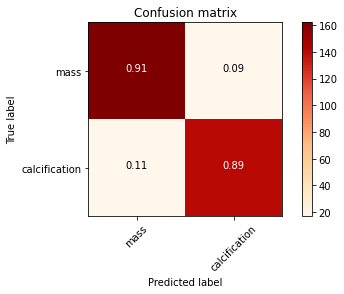

0.8988095238095238
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       179
           1       0.89      0.89      0.89       157

    accuracy                           0.90       336
   macro avg       0.90      0.90      0.90       336
weighted avg       0.90      0.90      0.90       336

[0 1]
Normalized confusion matrix


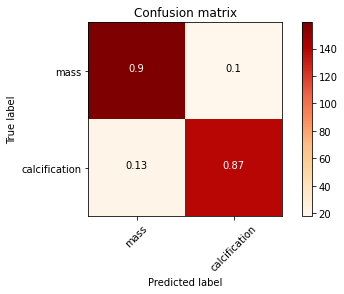

0.8869047619047619
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       179
           1       0.87      0.89      0.88       157

    accuracy                           0.89       336
   macro avg       0.89      0.89      0.89       336
weighted avg       0.89      0.89      0.89       336



In [ ]:
dir1 = projectPath + dir_name + "/task3_1/"
testSet = np.repeat(testSet,3, axis = 3)

model1 = keras.models.load_model(os.path.join(dir1, "model1.h5"))
pred1 = model1.predict_classes(testSet)
acc1 = metrics.accuracy_score(testLabels, pred1)

model2 = keras.models.load_model(os.path.join(dir1,"model2.h5"))
pred2 = model2.predict_classes(testSet)
acc2 = metrics.accuracy_score(testLabels, pred2)

model3 = keras.models.load_model(os.path.join(dir1,"model3.h5"))
pred3 = model3.predict_classes(testSet)
acc3 = metrics.accuracy_score(testLabels, pred3)

weights = [acc1, acc2, acc3]
models = [model1, model2, model3]

resAvg = ensemble_predictions_avg(models, weights, testSet)
resMaj = ensemble_predictions_majority(models, weights, testSet)


show_results(resAvg, testLabels, ['mass', 'calcification'])
print(metrics.classification_report(testLabels, resAvg))

show_results(resMaj, testLabels, ['mass', 'calcification'])
print(metrics.classification_report(testLabels, resMaj))

# **Ensamble 3.2**

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 1]
Normalized confusion matrix


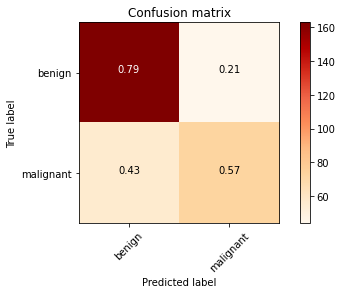

0.7023809523809523
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       219
           1       0.57      0.62      0.59       117

    accuracy                           0.70       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.71      0.70      0.71       336

[0 1]
Normalized confusion matrix


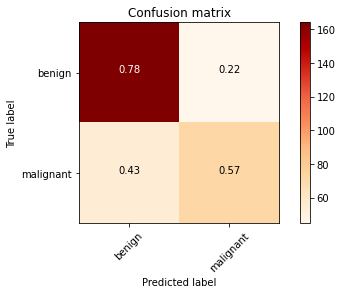

0.7023809523809523
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       219
           1       0.57      0.62      0.59       117

    accuracy                           0.70       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.71      0.70      0.71       336



In [ ]:
dir1 = projectPath + dir_name + "/task3_2/"
testSet2 = np.repeat(testSet2,3, axis = 3)

model1 = keras.models.load_model(os.path.join(dir1, "model1.h5"))
pred1 = model1.predict_classes(testSet2)
acc1 = metrics.accuracy_score(testLabels2, pred1)

model2 = keras.models.load_model(os.path.join(dir1,"model2.h5"))
pred2 = model2.predict_classes(testSet2)
acc2 = metrics.accuracy_score(testLabels2, pred2)

model3 = keras.models.load_model(os.path.join(dir1,"model3.h5"))
pred3 = model3.predict_classes(testSet2)
acc3 = metrics.accuracy_score(testLabels2, pred3)

weights = [acc1, acc2, acc3]
models = [model1, model2, model3]

resAvg = ensemble_predictions_avg(models, weights, testSet2)
resMaj = ensemble_predictions_majority(models, weights, testSet2)


show_results(resAvg, testLabels2, ['benign', 'malignant'])
print(metrics.classification_report(testLabels2, resAvg))

show_results(resMaj, testLabels2, ['benign', 'malignant'])
print(metrics.classification_report(testLabels2, resMaj))